In [28]:
import os
import torch
from typing import List, Callable
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.utils.data import TensorDataset, DataLoader
from math import factorial
from itertools import product

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Generate basis functions b_i(x, y) = x^p y^q / r! with p+q=r <= MAX_DEGREE
def generate_homogeneous_basis(max_degree: int):
    basis = []
    degrees = []  # (r = p + q)
    for r in range(max_degree + 1):
        for p in range(r + 1):
            q = r - p
            def monomial(p=p, q=q, r=r):
                return lambda X, Y: (X**p * Y**q) / factorial(r)
            basis.append(monomial())
            degrees.append(r)
    return basis, degrees

# Compute basis vector from image phi
def compute_basis_vector(phi: torch.Tensor) -> torch.Tensor:
    width, height = phi.shape
    k = torch.arange(width, device=phi.device) - width // 2
    j = torch.arange(height, device=phi.device) - height // 2
    X, Y = torch.meshgrid(k, j, indexing="ij")
    return torch.stack([(b(X, Y) * phi).sum() for b in BASIS])

# Precompute and cache dataset
def get_or_create_augmented_tensor_dataset(train: bool = True, limit: int | None = None, overwrite_cache: bool = False) -> TensorDataset:
    split_name = "train" if train else "test"
    limit_str = f"{limit}" if limit is not None else "all"
    CACHE_DIR = f"./data/scaled_mnist_limit{limit_str}_{split_name}_BaseDegree{MAX_DEGREE}"
    os.makedirs(CACHE_DIR, exist_ok=True)
    cache_path = os.path.join(CACHE_DIR, f"augmented_mnist_{split_name}.pt")

    if os.path.exists(cache_path) and not overwrite_cache:
        print(f"Loading cached dataset from: {cache_path}")
        dataset = torch.load(cache_path, weights_only=False)
        return TensorDataset(dataset.tensors[0].to(device), dataset.tensors[1].to(device))

    print(f"Creating augmented dataset for MNIST ({split_name})...")
    mnist_ds = MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())

    X_list, y_list = [], []

    for idx, (tensor_img, label) in enumerate(mnist_ds):
        if limit is not None and idx >= limit:
            break

        for scale in SCALES:
            for angle in ANGLES:
                transformed = F.affine(
                    tensor_img,
                    angle=angle,
                    translate=(0, 0),
                    scale=scale,
                    shear=(0.0, 0.0),
                    interpolation=InterpolationMode.NEAREST,
                    fill=0.0,
                    center=None,
                )
                phi = transformed.squeeze(0).to(device)  # (28, 28)
                vec = compute_basis_vector(phi)
                X_list.append(vec)
                y_list.append(label)

    X_tensor = torch.stack(X_list)
    y_tensor = torch.tensor(y_list, dtype=torch.long, device=device)

    dataset = TensorDataset(X_tensor, y_tensor)
    torch.save(dataset, cache_path)
    print(f"Saved dataset to: {cache_path}")

    return dataset

# Create data loaders
def get_data_loaders(batch_size: int = 512, limit: int | None = None, overwrite_cache: bool = False):
    train_ds = get_or_create_augmented_tensor_dataset(train=True, limit=limit, overwrite_cache=overwrite_cache)
    test_ds = get_or_create_augmented_tensor_dataset(train=False, limit=limit, overwrite_cache=overwrite_cache)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    return train_loader, test_loader


In [19]:
# Configuration
SCALES: List[float] = [0.3 + 0.1 * i for i in range(13)]  # 0.3 to 1.5
ANGLES: List[int] = [0]
MAX_DEGREE = 6 # Degree of the basis functions

BASIS, DEGREE_INFO = generate_homogeneous_basis(MAX_DEGREE)

print(len(BASIS))

28


In [33]:
train_loader, test_loader = get_data_loaders(batch_size=2048, limit=10000)

Loading cached dataset from: ./data/scaled_mnist_limit10000_train_BaseDegree6/augmented_mnist_train.pt
Loading cached dataset from: ./data/scaled_mnist_limit10000_test_BaseDegree6/augmented_mnist_test.pt


## Train util

In [22]:
import torch
from tqdm import trange
import matplotlib.pyplot as plt

def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Training loop
def train_models(num_epochs=1000, early_stop_patience=200):
    best_hnn_acc, best_mlp_acc = 0.0, 0.0
    patience = 0

    train_loss_h, test_loss_h = [], []
    train_loss_m, test_loss_m = [], []
    train_acc_h, test_acc_h = [], []
    train_acc_m, test_acc_m = [], []

    for epoch in trange(num_epochs, desc="Training Epochs"):
        model_hnn.train()
        model_mlp.train()
        epoch_loss_h, epoch_loss_m = 0.0, 0.0

        for x_batch, y_batch in train_loader:
            # HNN
            opt_hnn.zero_grad()
            out_hnn = model_hnn(x_batch)
            loss_h = criterion(out_hnn, y_batch)
            loss_h.backward()
            opt_hnn.step()
            epoch_loss_h += loss_h.item()

            # MLP
            opt_mlp.zero_grad()
            out_mlp = model_mlp(x_batch)
            loss_m = criterion(out_mlp, y_batch)
            loss_m.backward()
            opt_mlp.step()
            epoch_loss_m += loss_m.item()

        # Eval phase
        def eval_model(model):
            model.eval()
            total_loss, correct, total = 0.0, 0, 0
            with torch.no_grad():
                for x, y in test_loader:
                    preds = model(x)
                    loss = criterion(preds, y)
                    total_loss += loss.item()
                    correct += (preds.argmax(dim=1) == y).sum().item()
                    total += y.size(0)
            return total_loss / len(test_loader), correct / total

        # Record losses/accuracies
        train_loss_h.append(epoch_loss_h / len(train_loader))
        train_loss_m.append(epoch_loss_m / len(train_loader))

        val_loss_h, acc_h = eval_model(model_hnn)
        val_loss_m, acc_m = eval_model(model_mlp)

        test_loss_h.append(val_loss_h)
        test_loss_m.append(val_loss_m)
        test_acc_h.append(acc_h)
        test_acc_m.append(acc_m)

        train_acc_h.append(compute_accuracy(model_hnn, train_loader))
        train_acc_m.append(compute_accuracy(model_mlp, train_loader))

        # Logging
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: "
                  f"HNN Loss: {train_loss_h[-1]:.4f} / {val_loss_h:.4f}, "
                  f"Acc: {train_acc_h[-1]*100:.2f}% / {acc_h*100:.2f}% || "
                  f"MLP Loss: {train_loss_m[-1]:.4f} / {val_loss_m:.4f}, "
                  f"Acc: {train_acc_m[-1]*100:.2f}% / {acc_m*100:.2f}%")

        # Early stopping
        if acc_h > best_hnn_acc or acc_m > best_mlp_acc:
            best_hnn_acc = max(best_hnn_acc, acc_h)
            best_mlp_acc = max(best_mlp_acc, acc_m)
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return {
        "train_loss_h": train_loss_h, "test_loss_h": test_loss_h,
        "train_loss_m": train_loss_m, "test_loss_m": test_loss_m,
        "train_acc_h": train_acc_h, "test_acc_h": test_acc_h,
        "train_acc_m": train_acc_m, "test_acc_m": test_acc_m
    }

# --- Plot results
def plot_metrics(results):
    epochs = range(1, len(results["train_loss_h"]) + 1)

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["train_loss_h"], label="HNN Train")
    plt.plot(epochs, results["test_loss_h"], label="HNN Test")
    plt.plot(epochs, results["train_loss_m"], label="MLP Train", linestyle="--")
    plt.plot(epochs, results["test_loss_m"], label="MLP Test", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("CrossEntropy Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["train_acc_h"], label="HNN Train")
    plt.plot(epochs, results["test_acc_h"], label="HNN Test")
    plt.plot(epochs, results["train_acc_m"], label="MLP Train", linestyle="--")
    plt.plot(epochs, results["test_acc_m"], label="MLP Test", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.grid(True)
    plt.show()



## Train

In [34]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn
import torch.optim as optim

r_list = torch.tensor(DEGREE_INFO, dtype=torch.float32, device=device)
nu = 0.0
Gd = torch.diag(r_list + 2)
input_dim = len(BASIS)
P = torch.eye(input_dim, device=device)

# --- Define models ---
hidden_layers = 5
hidden_dim = 10
output_dim = 10

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)

model_hnn.apply(initialize_weights)

# MLP de référence pour la comparaison
class SimpleMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, hidden_layers = hidden_layers):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiate MLP model
model_mlp = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizer
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-4, weight_decay=1e-4)


Training Epochs:   0%|                          | 1/300 [00:05<28:40,  5.75s/it]

Epoch 1: HNN Loss: 2.3116 / 2.3076, Acc: 10.09% / 9.99% || MLP Loss: 2.4357 / 2.4017, Acc: 8.99% / 9.39%


Training Epochs:   3%|▊                        | 10/300 [00:57<27:41,  5.73s/it]

Epoch 10: HNN Loss: 2.2849 / 2.2834, Acc: 20.92% / 20.26% || MLP Loss: 2.2376 / 2.2365, Acc: 18.13% / 17.49%


Training Epochs:   7%|█▋                       | 20/300 [01:54<26:39,  5.71s/it]

Epoch 20: HNN Loss: 2.1230 / 2.1110, Acc: 21.91% / 21.25% || MLP Loss: 2.1120 / 2.1199, Acc: 22.70% / 21.86%


Training Epochs:  10%|██▌                      | 30/300 [02:52<25:50,  5.74s/it]

Epoch 30: HNN Loss: 2.0381 / 2.0297, Acc: 24.37% / 23.08% || MLP Loss: 2.0442 / 2.0596, Acc: 24.57% / 23.10%


Training Epochs:  13%|███▎                     | 40/300 [03:50<25:15,  5.83s/it]

Epoch 40: HNN Loss: 1.9651 / 1.9612, Acc: 26.94% / 25.54% || MLP Loss: 1.9787 / 1.9983, Acc: 26.68% / 25.27%


Training Epochs:  17%|████▏                    | 50/300 [04:48<24:12,  5.81s/it]

Epoch 50: HNN Loss: 1.8980 / 1.9008, Acc: 30.61% / 29.38% || MLP Loss: 1.9016 / 1.9272, Acc: 31.76% / 30.94%


Training Epochs:  20%|█████                    | 60/300 [05:46<23:01,  5.76s/it]

Epoch 60: HNN Loss: 1.8294 / 1.8366, Acc: 34.41% / 33.18% || MLP Loss: 1.8393 / 1.8697, Acc: 34.66% / 34.05%


Training Epochs:  23%|█████▊                   | 70/300 [06:45<22:31,  5.88s/it]

Epoch 70: HNN Loss: 1.7171 / 1.7274, Acc: 39.36% / 37.95% || MLP Loss: 1.7804 / 1.8110, Acc: 36.63% / 35.96%


Training Epochs:  27%|██████▋                  | 80/300 [07:42<21:00,  5.73s/it]

Epoch 80: HNN Loss: 1.6033 / 1.6158, Acc: 43.21% / 42.20% || MLP Loss: 1.7280 / 1.7567, Acc: 37.95% / 36.81%


Training Epochs:  30%|███████▌                 | 90/300 [08:40<20:01,  5.72s/it]

Epoch 90: HNN Loss: 1.5275 / 1.5423, Acc: 45.64% / 44.80% || MLP Loss: 1.6943 / 1.7246, Acc: 39.80% / 38.23%


Training Epochs:  33%|████████                | 100/300 [09:37<19:14,  5.77s/it]

Epoch 100: HNN Loss: 1.4741 / 1.4925, Acc: 47.61% / 46.83% || MLP Loss: 1.6738 / 1.7041, Acc: 40.89% / 39.43%


Training Epochs:  37%|████████▊               | 110/300 [10:35<18:11,  5.74s/it]

Epoch 110: HNN Loss: 1.4345 / 1.4564, Acc: 49.26% / 48.45% || MLP Loss: 1.6506 / 1.6818, Acc: 41.93% / 40.55%


Training Epochs:  40%|█████████▌              | 120/300 [11:34<17:40,  5.89s/it]

Epoch 120: HNN Loss: 1.4042 / 1.4300, Acc: 50.28% / 49.43% || MLP Loss: 1.6379 / 1.6713, Acc: 42.15% / 40.81%


Training Epochs:  43%|██████████▍             | 130/300 [12:31<16:19,  5.76s/it]

Epoch 130: HNN Loss: 1.3787 / 1.4074, Acc: 51.01% / 50.19% || MLP Loss: 1.6248 / 1.6582, Acc: 42.54% / 41.03%


Training Epochs:  47%|███████████▏            | 140/300 [13:32<16:46,  6.29s/it]

Epoch 140: HNN Loss: 1.3566 / 1.3877, Acc: 52.07% / 51.16% || MLP Loss: 1.6136 / 1.6444, Acc: 42.63% / 41.28%


Training Epochs:  50%|████████████            | 150/300 [14:33<15:00,  6.01s/it]

Epoch 150: HNN Loss: 1.3369 / 1.3689, Acc: 52.79% / 51.88% || MLP Loss: 1.6042 / 1.6358, Acc: 42.97% / 41.76%


Training Epochs:  53%|████████████▊           | 160/300 [15:33<13:43,  5.88s/it]

Epoch 160: HNN Loss: 1.3192 / 1.3516, Acc: 53.60% / 52.72% || MLP Loss: 1.5953 / 1.6269, Acc: 43.09% / 41.95%


Training Epochs:  57%|█████████████▌          | 170/300 [16:33<12:41,  5.86s/it]

Epoch 170: HNN Loss: 1.3009 / 1.3334, Acc: 54.56% / 53.62% || MLP Loss: 1.5898 / 1.6239, Acc: 43.23% / 42.04%


Training Epochs:  60%|██████████████▍         | 180/300 [17:33<11:56,  5.97s/it]

Epoch 180: HNN Loss: 1.2820 / 1.3132, Acc: 55.51% / 54.67% || MLP Loss: 1.5832 / 1.6174, Acc: 43.22% / 41.93%


Training Epochs:  63%|███████████████▏        | 190/300 [18:35<11:42,  6.39s/it]

Epoch 190: HNN Loss: 1.2599 / 1.2891, Acc: 56.57% / 55.83% || MLP Loss: 1.5777 / 1.6126, Acc: 43.64% / 42.21%


Training Epochs:  67%|████████████████        | 200/300 [19:38<10:45,  6.46s/it]

Epoch 200: HNN Loss: 1.2309 / 1.2612, Acc: 57.86% / 57.19% || MLP Loss: 1.5709 / 1.6072, Acc: 43.81% / 42.28%


Training Epochs:  70%|████████████████▊       | 210/300 [20:39<09:06,  6.07s/it]

Epoch 210: HNN Loss: 1.1973 / 1.2254, Acc: 59.43% / 58.69% || MLP Loss: 1.5663 / 1.6026, Acc: 43.87% / 42.50%


Training Epochs:  73%|█████████████████▌      | 220/300 [21:38<07:43,  5.80s/it]

Epoch 220: HNN Loss: 1.1613 / 1.1892, Acc: 60.77% / 60.09% || MLP Loss: 1.5628 / 1.5976, Acc: 44.11% / 42.70%


Training Epochs:  77%|██████████████████▍     | 230/300 [22:36<06:40,  5.72s/it]

Epoch 230: HNN Loss: 1.1308 / 1.1618, Acc: 61.89% / 60.97% || MLP Loss: 1.5584 / 1.5916, Acc: 44.29% / 43.04%


Training Epochs:  80%|███████████████████▏    | 240/300 [23:36<06:04,  6.08s/it]

Epoch 240: HNN Loss: 1.1096 / 1.1428, Acc: 62.63% / 61.58% || MLP Loss: 1.5534 / 1.5898, Acc: 44.51% / 43.19%


Training Epochs:  83%|████████████████████    | 250/300 [24:36<05:03,  6.08s/it]

Epoch 250: HNN Loss: 1.0944 / 1.1306, Acc: 63.09% / 61.92% || MLP Loss: 1.5490 / 1.5859, Acc: 44.53% / 43.30%


Training Epochs:  87%|████████████████████▊   | 260/300 [25:37<04:03,  6.08s/it]

Epoch 260: HNN Loss: 1.0829 / 1.1201, Acc: 63.54% / 62.43% || MLP Loss: 1.5452 / 1.5819, Acc: 44.44% / 43.36%


Training Epochs:  90%|█████████████████████▌  | 270/300 [26:38<03:01,  6.05s/it]

Epoch 270: HNN Loss: 1.0733 / 1.1122, Acc: 63.88% / 62.74% || MLP Loss: 1.5393 / 1.5741, Acc: 44.95% / 43.71%


Training Epochs:  93%|██████████████████████▍ | 280/300 [27:38<02:01,  6.06s/it]

Epoch 280: HNN Loss: 1.0655 / 1.1063, Acc: 64.08% / 62.96% || MLP Loss: 1.5343 / 1.5720, Acc: 44.79% / 43.56%


Training Epochs:  97%|███████████████████████▏| 290/300 [28:37<00:58,  5.84s/it]

Epoch 290: HNN Loss: 1.0593 / 1.1000, Acc: 64.38% / 63.18% || MLP Loss: 1.5276 / 1.5640, Acc: 45.10% / 43.72%


Training Epochs: 100%|████████████████████████| 300/300 [29:36<00:00,  5.92s/it]

Epoch 300: HNN Loss: 1.0525 / 1.0950, Acc: 64.59% / 63.42% || MLP Loss: 1.5223 / 1.5608, Acc: 45.21% / 43.71%


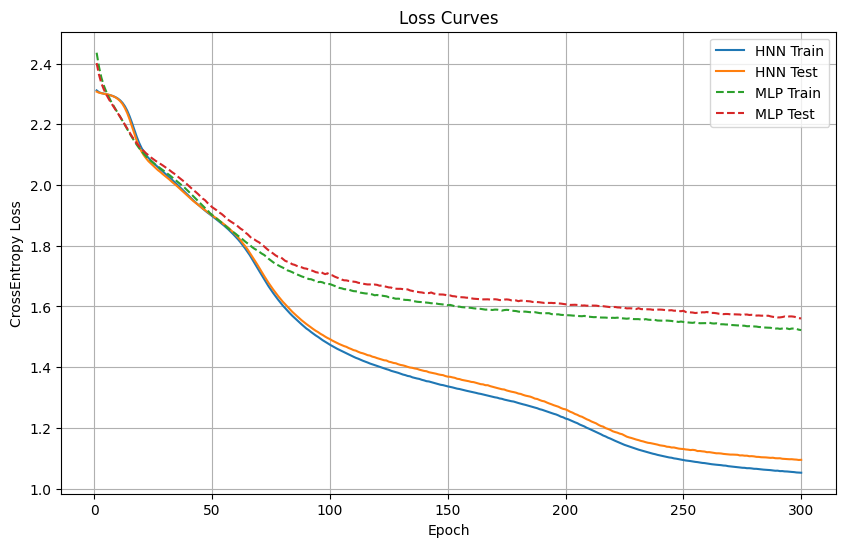

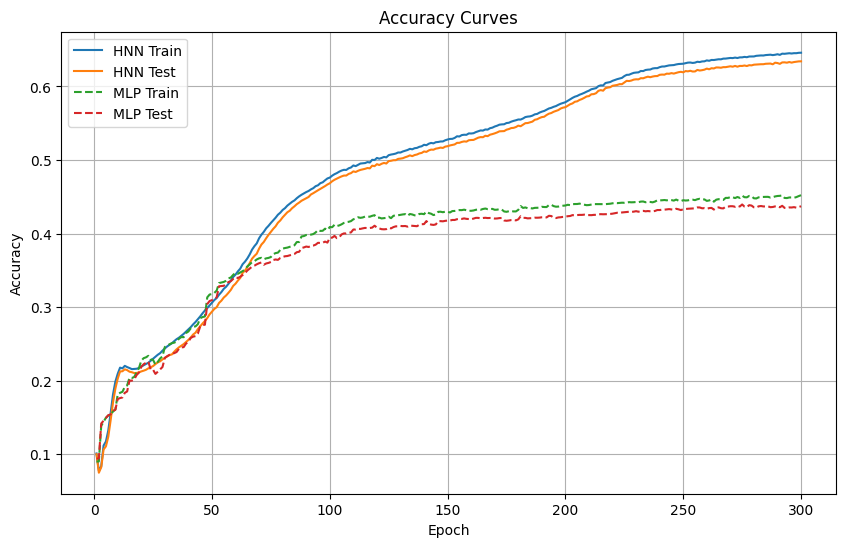

In [35]:
# --- Run training
results = train_models(num_epochs=300)
plot_metrics(results)

In [36]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn
import torch.optim as optim

r_list = torch.tensor(DEGREE_INFO, dtype=torch.float32, device=device)
nu = 0.0
Gd = torch.diag(r_list + 2)
input_dim = len(BASIS)
P = torch.eye(input_dim, device=device)

# --- Define models ---
hidden_layers = 5
hidden_dim = 10
output_dim = 10

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)

model_hnn.apply(initialize_weights)

# MLP de référence pour la comparaison
class SimpleMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, hidden_layers = hidden_layers):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiate MLP model
model_mlp = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizer
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-4, weight_decay=1e-4)


In [ ]:
results = train_models(num_epochs=1000)
plot_metrics(results)

Training Epochs:   0%|                       | 1/1000 [00:06<1:42:25,  6.15s/it]

Epoch 1: HNN Loss: 2.3116 / 2.3076, Acc: 10.09% / 9.99% || MLP Loss: 2.4357 / 2.4017, Acc: 8.99% / 9.39%


Training Epochs:   1%|▏                     | 10/1000 [00:58<1:35:12,  5.77s/it]

Epoch 10: HNN Loss: 2.2849 / 2.2834, Acc: 20.92% / 20.26% || MLP Loss: 2.2376 / 2.2365, Acc: 18.13% / 17.49%


Training Epochs:   2%|▍                     | 20/1000 [01:56<1:33:50,  5.75s/it]

Epoch 20: HNN Loss: 2.1230 / 2.1110, Acc: 21.91% / 21.25% || MLP Loss: 2.1120 / 2.1199, Acc: 22.70% / 21.86%


Training Epochs:   3%|▋                     | 30/1000 [02:54<1:33:44,  5.80s/it]

Epoch 30: HNN Loss: 2.0381 / 2.0297, Acc: 24.37% / 23.08% || MLP Loss: 2.0442 / 2.0596, Acc: 24.57% / 23.10%


Training Epochs:   4%|▉                     | 40/1000 [03:52<1:33:37,  5.85s/it]

Epoch 40: HNN Loss: 1.9651 / 1.9612, Acc: 26.94% / 25.54% || MLP Loss: 1.9787 / 1.9983, Acc: 26.68% / 25.27%


Training Epochs:   5%|█                     | 50/1000 [04:51<1:33:59,  5.94s/it]

Epoch 50: HNN Loss: 1.8980 / 1.9008, Acc: 30.61% / 29.38% || MLP Loss: 1.9016 / 1.9272, Acc: 31.76% / 30.94%


Training Epochs:   6%|█▎                    | 60/1000 [05:50<1:32:44,  5.92s/it]

Epoch 60: HNN Loss: 1.8294 / 1.8366, Acc: 34.41% / 33.18% || MLP Loss: 1.8393 / 1.8697, Acc: 34.66% / 34.05%


Training Epochs:   7%|█▌                    | 70/1000 [06:49<1:29:52,  5.80s/it]

Epoch 70: HNN Loss: 1.7171 / 1.7274, Acc: 39.36% / 37.95% || MLP Loss: 1.7804 / 1.8110, Acc: 36.63% / 35.96%


Training Epochs:   8%|█▊                    | 80/1000 [07:48<1:28:20,  5.76s/it]

Epoch 80: HNN Loss: 1.6033 / 1.6158, Acc: 43.21% / 42.20% || MLP Loss: 1.7280 / 1.7567, Acc: 37.95% / 36.81%


Training Epochs:   9%|█▉                    | 90/1000 [08:47<1:30:58,  6.00s/it]

Epoch 90: HNN Loss: 1.5275 / 1.5423, Acc: 45.64% / 44.80% || MLP Loss: 1.6943 / 1.7246, Acc: 39.80% / 38.23%


Training Epochs:  10%|██                   | 100/1000 [09:48<1:30:44,  6.05s/it]

Epoch 100: HNN Loss: 1.4741 / 1.4925, Acc: 47.61% / 46.83% || MLP Loss: 1.6738 / 1.7041, Acc: 40.89% / 39.43%


Training Epochs:  11%|██▎                  | 110/1000 [10:47<1:29:41,  6.05s/it]

Epoch 110: HNN Loss: 1.4345 / 1.4564, Acc: 49.26% / 48.45% || MLP Loss: 1.6506 / 1.6818, Acc: 41.93% / 40.55%


Training Epochs:  12%|██▌                  | 120/1000 [11:49<1:30:52,  6.20s/it]

Epoch 120: HNN Loss: 1.4042 / 1.4300, Acc: 50.28% / 49.43% || MLP Loss: 1.6379 / 1.6713, Acc: 42.15% / 40.81%


Training Epochs:  13%|██▋                  | 130/1000 [12:51<1:29:22,  6.16s/it]

Epoch 130: HNN Loss: 1.3787 / 1.4074, Acc: 51.01% / 50.19% || MLP Loss: 1.6248 / 1.6582, Acc: 42.54% / 41.03%


Training Epochs:  14%|██▉                  | 140/1000 [13:53<1:29:42,  6.26s/it]

Epoch 140: HNN Loss: 1.3566 / 1.3877, Acc: 52.07% / 51.16% || MLP Loss: 1.6136 / 1.6444, Acc: 42.63% / 41.28%


Training Epochs:  15%|███▏                 | 150/1000 [15:06<1:26:42,  6.12s/it]

Epoch 150: HNN Loss: 1.3369 / 1.3689, Acc: 52.79% / 51.88% || MLP Loss: 1.6042 / 1.6358, Acc: 42.97% / 41.76%


Training Epochs:  16%|███▎                 | 160/1000 [16:03<1:20:35,  5.76s/it]

Epoch 160: HNN Loss: 1.3192 / 1.3516, Acc: 53.60% / 52.72% || MLP Loss: 1.5953 / 1.6269, Acc: 43.09% / 41.95%


Training Epochs:  17%|███▌                 | 170/1000 [17:01<1:20:22,  5.81s/it]

Epoch 170: HNN Loss: 1.3009 / 1.3334, Acc: 54.56% / 53.62% || MLP Loss: 1.5898 / 1.6239, Acc: 43.23% / 42.04%


Training Epochs:  18%|███▊                 | 180/1000 [17:59<1:21:28,  5.96s/it]

Epoch 180: HNN Loss: 1.2820 / 1.3132, Acc: 55.51% / 54.67% || MLP Loss: 1.5832 / 1.6174, Acc: 43.22% / 41.93%


Training Epochs:  19%|███▉                 | 190/1000 [18:58<1:17:22,  5.73s/it]

Epoch 190: HNN Loss: 1.2599 / 1.2891, Acc: 56.57% / 55.83% || MLP Loss: 1.5777 / 1.6126, Acc: 43.64% / 42.21%


Training Epochs:  20%|████▏                | 200/1000 [19:56<1:18:19,  5.87s/it]

Epoch 200: HNN Loss: 1.2309 / 1.2612, Acc: 57.86% / 57.19% || MLP Loss: 1.5709 / 1.6072, Acc: 43.81% / 42.28%


Training Epochs:  21%|████▍                | 210/1000 [20:55<1:17:12,  5.86s/it]

Epoch 210: HNN Loss: 1.1973 / 1.2254, Acc: 59.43% / 58.69% || MLP Loss: 1.5663 / 1.6026, Acc: 43.87% / 42.50%


Training Epochs:  22%|████▌                | 220/1000 [21:53<1:15:19,  5.79s/it]

Epoch 220: HNN Loss: 1.1613 / 1.1892, Acc: 60.77% / 60.09% || MLP Loss: 1.5628 / 1.5976, Acc: 44.11% / 42.70%


Training Epochs:  23%|████▊                | 230/1000 [22:51<1:14:04,  5.77s/it]

Epoch 230: HNN Loss: 1.1308 / 1.1618, Acc: 61.89% / 60.97% || MLP Loss: 1.5584 / 1.5916, Acc: 44.29% / 43.04%


Training Epochs:  24%|█████                | 240/1000 [23:50<1:15:42,  5.98s/it]

Epoch 240: HNN Loss: 1.1096 / 1.1428, Acc: 62.63% / 61.58% || MLP Loss: 1.5534 / 1.5898, Acc: 44.51% / 43.19%


Training Epochs:  25%|█████▎               | 250/1000 [24:50<1:14:19,  5.95s/it]

Epoch 250: HNN Loss: 1.0944 / 1.1306, Acc: 63.09% / 61.92% || MLP Loss: 1.5490 / 1.5859, Acc: 44.53% / 43.30%


Training Epochs:  26%|█████▍               | 260/1000 [25:48<1:11:52,  5.83s/it]

Epoch 260: HNN Loss: 1.0829 / 1.1201, Acc: 63.54% / 62.43% || MLP Loss: 1.5452 / 1.5819, Acc: 44.44% / 43.36%


Training Epochs:  27%|█████▋               | 270/1000 [26:46<1:11:11,  5.85s/it]

Epoch 270: HNN Loss: 1.0733 / 1.1122, Acc: 63.88% / 62.74% || MLP Loss: 1.5393 / 1.5741, Acc: 44.95% / 43.71%


Training Epochs:  28%|█████▉               | 280/1000 [27:45<1:10:08,  5.84s/it]

Epoch 280: HNN Loss: 1.0655 / 1.1063, Acc: 64.08% / 62.96% || MLP Loss: 1.5343 / 1.5720, Acc: 44.79% / 43.56%


Training Epochs:  29%|██████               | 290/1000 [28:44<1:10:53,  5.99s/it]

Epoch 290: HNN Loss: 1.0593 / 1.1000, Acc: 64.38% / 63.18% || MLP Loss: 1.5276 / 1.5640, Acc: 45.10% / 43.72%


Training Epochs:  30%|██████▎              | 300/1000 [29:45<1:10:27,  6.04s/it]

Epoch 300: HNN Loss: 1.0525 / 1.0950, Acc: 64.59% / 63.42% || MLP Loss: 1.5223 / 1.5608, Acc: 45.21% / 43.71%


Training Epochs:  31%|██████▌              | 310/1000 [30:44<1:08:44,  5.98s/it]

Epoch 310: HNN Loss: 1.0477 / 1.0891, Acc: 64.83% / 63.61% || MLP Loss: 1.5150 / 1.5543, Acc: 45.70% / 44.00%


Training Epochs:  32%|██████▋              | 320/1000 [31:43<1:06:06,  5.83s/it]

Epoch 320: HNN Loss: 1.0411 / 1.0842, Acc: 65.06% / 63.84% || MLP Loss: 1.5102 / 1.5507, Acc: 46.07% / 44.40%


Training Epochs:  33%|██████▉              | 330/1000 [32:42<1:07:11,  6.02s/it]

Epoch 330: HNN Loss: 1.0371 / 1.0795, Acc: 65.17% / 64.00% || MLP Loss: 1.5061 / 1.5471, Acc: 46.11% / 44.43%


Training Epochs:  34%|███████▏             | 340/1000 [33:42<1:06:05,  6.01s/it]

Epoch 340: HNN Loss: 1.0326 / 1.0767, Acc: 65.37% / 64.10% || MLP Loss: 1.5019 / 1.5437, Acc: 46.27% / 44.69%


Training Epochs:  35%|███████▎             | 350/1000 [34:43<1:04:01,  5.91s/it]

Epoch 350: HNN Loss: 1.0284 / 1.0712, Acc: 65.53% / 64.31% || MLP Loss: 1.4938 / 1.5350, Acc: 46.45% / 44.89%


Training Epochs:  36%|███████▌             | 360/1000 [35:44<1:05:07,  6.11s/it]

Epoch 360: HNN Loss: 1.0239 / 1.0678, Acc: 65.70% / 64.44% || MLP Loss: 1.4906 / 1.5286, Acc: 46.60% / 45.13%


Training Epochs:  37%|███████▊             | 370/1000 [36:43<1:03:00,  6.00s/it]

Epoch 370: HNN Loss: 1.0204 / 1.0634, Acc: 65.82% / 64.56% || MLP Loss: 1.4863 / 1.5257, Acc: 46.95% / 45.40%


Training Epochs:  38%|███████▉             | 380/1000 [37:46<1:03:59,  6.19s/it]

Epoch 380: HNN Loss: 1.0164 / 1.0588, Acc: 65.99% / 64.74% || MLP Loss: 1.4812 / 1.5246, Acc: 46.91% / 45.43%


Training Epochs:  39%|████████▏            | 390/1000 [38:45<1:00:54,  5.99s/it]

Epoch 390: HNN Loss: 1.0124 / 1.0560, Acc: 66.10% / 64.77% || MLP Loss: 1.4780 / 1.5187, Acc: 47.29% / 45.74%


Training Epochs:  40%|█████████▏             | 400/1000 [39:46<59:50,  5.98s/it]

Epoch 400: HNN Loss: 1.0083 / 1.0509, Acc: 66.26% / 65.01% || MLP Loss: 1.4737 / 1.5177, Acc: 47.45% / 45.96%


Training Epochs:  41%|█████████▍             | 410/1000 [40:45<58:22,  5.94s/it]

Epoch 410: HNN Loss: 1.0049 / 1.0481, Acc: 66.41% / 65.11% || MLP Loss: 1.4691 / 1.5139, Acc: 47.64% / 46.03%


Training Epochs:  41%|█████████▌             | 414/1000 [41:09<57:24,  5.88s/it]